In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from joblib import Parallel, delayed, cpu_count

from copy import deepcopy as copy
from scipy.linalg import eig
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline

import sys
import warnings

warnings.filterwarnings("ignore")

### Preliminary investigation of the data - PCA + KMeans Scree Plot using sklearn

In [2]:
data = np.loadtxt("high_variance_distances.dat")
data_pts = data.copy()
print(data.shape)

(7500, 177)


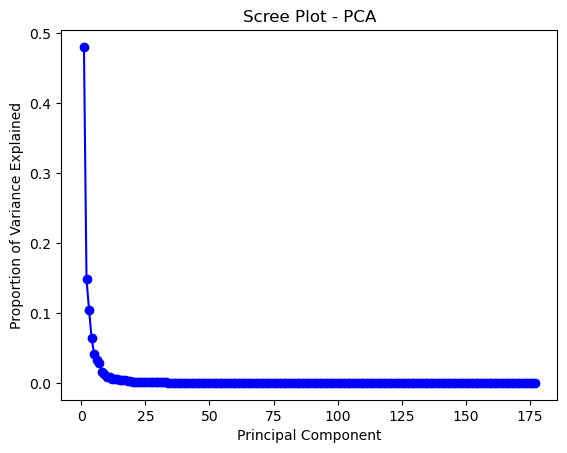

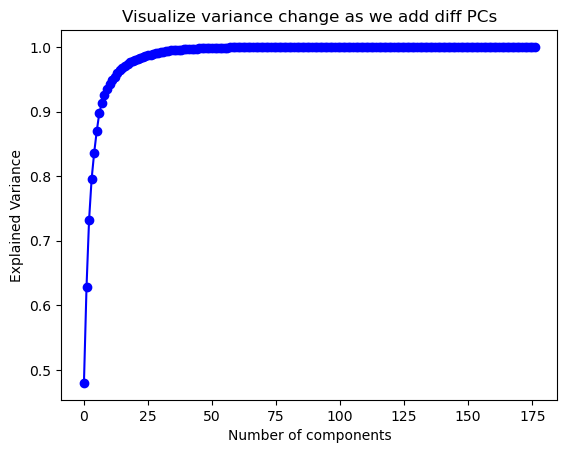

50
150
250
350
450
550
650
750
850
950
CPU times: user 8min 37s, sys: 1min 44s, total: 10min 22s
Wall time: 1min 18s


In [3]:
%%time

pca = PCA()
pca.fit(data)
new_data = pca.transform(data)

PC_values = np.arange(pca.n_components_) + 1

plt.title("Scree Plot - PCA")
plt.plot(PC_values, pca.explained_variance_ratio_, "bo-")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()

plt.title("Visualize variance change as we add diff PCs")
plt.ylabel("Explained Variance")
plt.xlabel("Number of components")
plt.plot(np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.show()

# Sklearn Kmeans error estimation to be used for comparing with my own code later
obj_list_skl = []
kmin = 50
kmax = 1050
kstep = 100
for k in range(kmin, kmax, kstep):
    print(k)
    kmeans_skl = KMeans(n_clusters=k).fit(data)
    obj_min = kmeans_skl.inertia_
    obj_list_skl.append(obj_min)

# Find microstates by KMeans/KMeans++/KMedoids

In [4]:
# testing

tmp_data = data.copy()
nc = 11
sel = np.random.choice(np.shape(tmp_data)[0], size=nc, replace=False)
cp = tmp_data[sel]

d2mat = cdist(tmp_data, cp, "sqeuclidean")
min_d2mat = np.array([np.min(d2mat, axis=1)])
tmp_labels = np.argmin(d2mat, axis=1)
tmp_loss = min_d2mat.sum()

new_cp = np.array([tmp_data[tmp_labels == i].mean(axis=0) for i in range(nc)])

print(d2mat.shape)
print(d2mat.mean(axis=0).shape)
print(d2mat.mean(axis=1).shape)
print(cp.shape)
print(new_cp.shape)
print(tmp_labels.shape)
print(min_d2mat.shape)
print(tmp_loss)
print(new_cp.shape)
print(tmp_data[tmp_labels == 1].shape)
print(tmp_data[tmp_labels == 2].shape)
print(tmp_data[tmp_labels == 2].mean(axis=0).shape)


i = rd.randint(0, np.shape(tmp_data)[0] - 1)
tmp_pp_cp = np.array([data[i]])

print(i)
print(tmp_pp_cp.shape)

cki = np.where(tmp_labels == 3)[0]
print(cki.shape)

tmp_D = cdist(data, data, "sqeuclidean")
tmp_c_k_idxs = np.where(tmp_labels == 2)[0]
print(tmp_c_k_idxs.shape)
tmp_intra_cluster_distances = tmp_D[tmp_c_k_idxs, tmp_c_k_idxs[:, np.newaxis]]
tmp_intra_cluster_costs = np.sum(tmp_intra_cluster_distances, axis=1)
print(tmp_intra_cluster_distances.shape)
print(tmp_intra_cluster_costs.shape)

(7500, 11)
(11,)
(7500,)
(11, 177)
(11, 177)
(7500,)
(1, 7500)
5975663.559033461
(11, 177)
(1111, 177)
(286, 177)
(177,)
4849
(1, 177)
(545,)
(286,)
(286, 286)
(286,)


In [5]:
class kmeans:
    # Initialize the class
    def __init__(self, num_clusters):
        self.num_centroids = num_clusters

    # Function for random initialization
    def init_centroids_random(self):
        # select a random sample of points of size=num_centroids from the total no. of points
        # this random sample acts as initial guesses for cluster centres -> data[select] does that bit
        select_centroids = np.random.choice(self.num_points, size=self.num_centroids, replace=False)
        return self.data[select_centroids]

    # Function for KMeans++ initialization
    def init_centroids_pp(self):
        # choose the first cluster centre at random
        i = rd.randint(0, self.num_points - 1)
        init_centroid = np.array([self.data[i]])

        centroids = init_centroid

        # do till all 'k' cluster centres have been found
        for k in range(1, self.num_centroids):
            D = np.array([])

            # find min distance to already assigned cluster centre/(s) so far
            D = np.append(D, np.min(cdist(self.data, centroids, "sqeuclidean"), axis=1))

            # get the probabilities
            prob = D / np.sum(D)
            cum_prob = np.cumsum(prob)

            # choose a random number to accept or reject new cluster centre (monte-carlo style)
            r = rd.random()
            l = 0
            # we prefer points at larger distances
            for j, p in enumerate(cum_prob):
                if r < p:
                    l = j
                    break

            # new centroid is selected with prob proportional to D
            centroids = np.append(centroids, [self.data[l]], axis=0)
            
        return centroids

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, init="random", max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]

        if init == "k-means++":
            self.centroid_positions = self.init_centroids_pp()
        else:
            self.centroid_positions = self.init_centroids_random()

        # do till maximum iterations reached/convergence achieved
        for count in range(max_iterations):
            # compute distances between each data point and each potential cluster it can be assigned
            dist_sq_matrix = cdist(self.data, self.centroid_positions, "sqeuclidean")

            # choose the minimum distance since that is where the loss is least
            # and that is where it will be assigned
            # so it is used to compute the loss
            min_dist = np.array([np.min(dist_sq_matrix, axis=1)])

            # the cluster to which dist is least is the cluster assigned for a point
            self.labels = np.argmin(dist_sq_matrix, axis=1)

            loss = min_dist.sum()

            # if a cluster has 0 points, reinitialize till it does
            skip = False
            for i in range(self.num_centroids):
                if len(self.data[self.labels == i]) == 0:
                    skip = True
            if skip == True:
                self.centroid_positions = self.init_centroids_random()
                continue

            # mean position of points assigned to a cluster is the new cluster centre (centroid)
            new_centroids = np.array(
                [self.data[self.labels == i].mean(axis=0) for i in range(self.num_centroids)]
            )

            # if all cluster centres remain unchanged, Kmeans has converged
            if np.all(self.centroid_positions == new_centroids):
                break
            self.centroid_positions = new_centroids

        # if max iterations is reached without convergence, then exit and let the user know
        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, new_centroids, self.labels

    # Plot Clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_centroids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for centroid in range(self.num_centroids):
            array_points = self.data[self.labels == centroid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[centroid], s=4)
        plt.scatter(self.centroid_positions[:, 0], self.centroid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final centroid positions
    def get_centroid_positions(self):
        return self.centroid_positions

In [6]:
class kmedoids:
    # Initialize the class
    def __init__(self, num_medoids):
        self.num_medoids = num_medoids

    # Function for random initialization
    def init_medoids_random(self):
        init_medoid_idxs = np.random.choice(self.num_points, size=self.num_medoids, replace=False)
        return init_medoid_idxs

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]

        # get initial guesses for which points are chosen as medoids
        medoid_idxs = self.init_medoids_random()

        # compute distances of each point to each other
        D = cdist(self.data, self.data, "sqeuclidean")

        for count in range(max_iterations):
            old_medoid_idxs = np.copy(medoid_idxs)

            # the minimum distance of a point to a medoid is the cluster assigned to that point
            labels = np.argmin(D[medoid_idxs, :], axis=0)

            # get new medoids
            self.update_medoids(D, labels, medoid_idxs)

            # if they don't change, then KMedoids has converged
            if np.all(old_medoid_idxs == medoid_idxs):
                break

        # new medoid positions are updated
        self.medoid_positions = self.data[medoid_idxs]

        # new labels are updated
        self.labels = np.argmin(D[medoid_idxs, :], axis=0)

        # distance of each point to all medoids is taken to compute loss function values
        dist_sq_matrix = cdist(self.data, self.medoid_positions, "sqeuclidean")
        min_dist = np.array([np.min(dist_sq_matrix, axis=1)])
        loss = min_dist.sum()

        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, self.medoid_positions, self.labels

    # Function to update medoid positions
    def update_medoids(self, D, labels, medoid_idxs):

        for k in range(self.num_medoids):

            # the indices that are labelled by medoid number 'k'
            cluster_k_indexes = np.where(labels == k)[0]

            # if 0 indices are labelled by a medoid, then skip
            if len(cluster_k_indexes) == 0:
                continue

            # distance between all the points assigned to a given medoid
            intra_cluster_distances = D[cluster_k_indexes, cluster_k_indexes[:, np.newaxis]]

            # minimum cost function for which point
            intra_cluster_all_costs = np.sum(intra_cluster_distances, axis=1)
            min_cost_index = np.argmin(intra_cluster_all_costs)
            min_cost = intra_cluster_all_costs[min_cost_index]

            # current cost is cost at the argmax of the indices belonging to kth medoid
            curr_cost = intra_cluster_all_costs[np.argmax(cluster_k_indexes == medoid_idxs[k])]

            # if cost can be reduced, then update the medoid indices
            if min_cost < curr_cost:
                medoid_idxs[k] = cluster_k_indexes[min_cost_index]

    # Plot the clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_medoids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for medoid in range(self.num_medoids):
            array_points = self.data[self.labels == medoid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[medoid], s=4)
        plt.scatter(self.medoid_positions[:, 0], self.medoid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final medoid positions
    def get_medoid_positions(self):
        return self.medoid_positions

In [7]:
def plot_clusters(data, centroids, labels):
    colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, centroids.shape[0]))

    for i in range(centroids.shape[0]):
        cluster = data[labels == i]
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], s=4)

    title_text = "N = %d, k = %d" % (centroids.shape[0], labels.shape[0])
    plt.title(title_text)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="k")
    plt.show()

## Test for KMeans (random initialization)

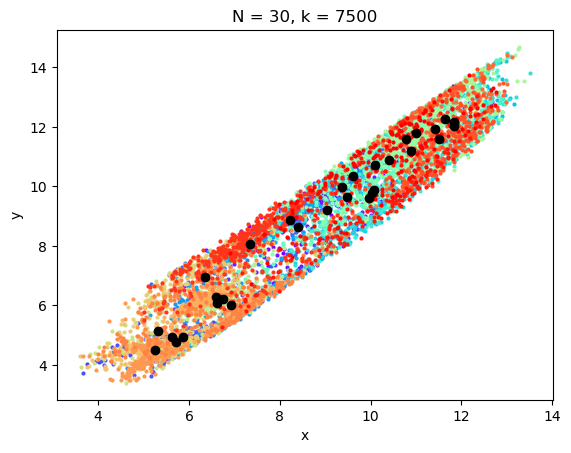

Average Loss =  2677719.0183297023
Minimum Loss =  2649030.8991186954
Simulation Run corresponding to least loss =  7
Average number of iterations to converge =  49.5
CPU times: user 257 ms, sys: 134 ms, total: 391 ms
Wall time: 3.53 s


In [8]:
%%time

num_simulations = 10
test_km = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_km.fit)(data, init="random") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMeans (K-Means++ initialization)

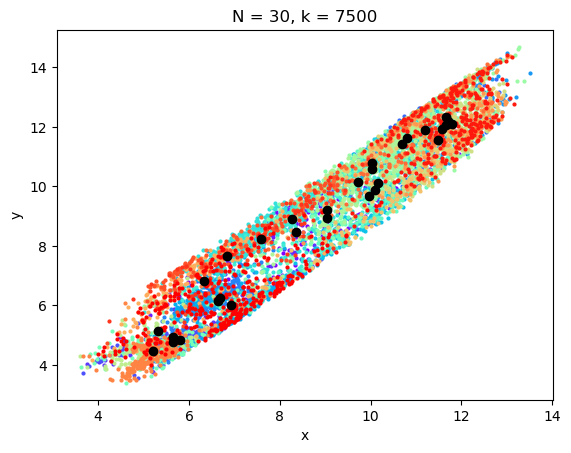

Average Loss =  2669671.865752066
Minimum Loss =  2645895.7649361333
Simulation Run corresponding to least loss =  2
Average number of iterations to converge =  41.5
CPU times: user 195 ms, sys: 7.44 ms, total: 202 ms
Wall time: 1.72 s


In [9]:
%%time

num_simulations = 10
test_kmpp = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmpp.fit)(data, init="k-means++") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMedoids

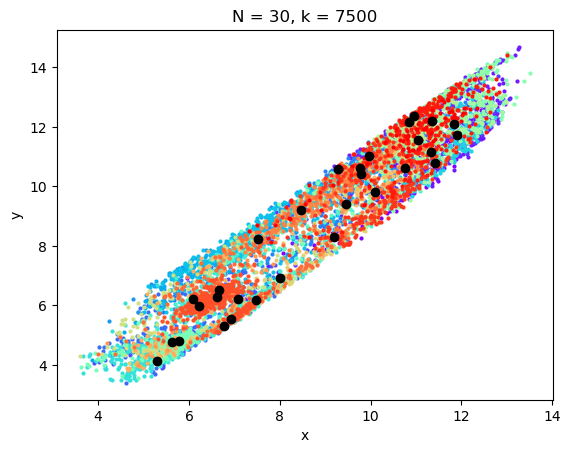

Average Loss =  3738105.409617728
Minimum Loss =  3632841.6781128235
Simulation Run corresponding to least loss =  8
Average number of iterations to converge =  3.1
CPU times: user 196 ms, sys: 19.3 ms, total: 216 ms
Wall time: 5.76 s


In [10]:
%%time

num_simulations = 10
test_kmed = kmedoids(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmed.fit)(data) for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

### Based on these preliminary tests, error is minimum for KMeans++. But random initialization is pretty close and is way faster, so we proceed with that. We ignore KMedoids which has a much higher error.

### Now, let's do a scree plot for KMeans to try and choose an appropriate 'k' for future steps.

In [11]:
%%time

num_simulations = 10
res_k = []

kmin = 50
kmax = 1050
kstep = 100

for k in range(kmin, kmax, kstep):
    print(k)
    km = kmeans(k)

    results = Parallel(n_jobs=-1)(delayed(km.fit)(data, init="random") for i in range(num_simulations))
    losses = np.array([results[i][0] for i in range(num_simulations)])
    min_loss = results[np.argmin(losses)][0]

    print(k, min_loss)
    res_k.append([k, min_loss])

res_k = np.array(res_k)

50
50 2303267.022783244
150
150 1697843.638947903
250
250 1483516.7111577906
350
350 1350240.611784804
450
450 1260233.56815899
550
550 1184179.8705983215
650
650 1128076.3944704453
750
750 1078028.3469839967
850
850 1028088.8284746663
950
950 990238.4689364323
CPU times: user 308 ms, sys: 108 ms, total: 416 ms
Wall time: 1min 5s


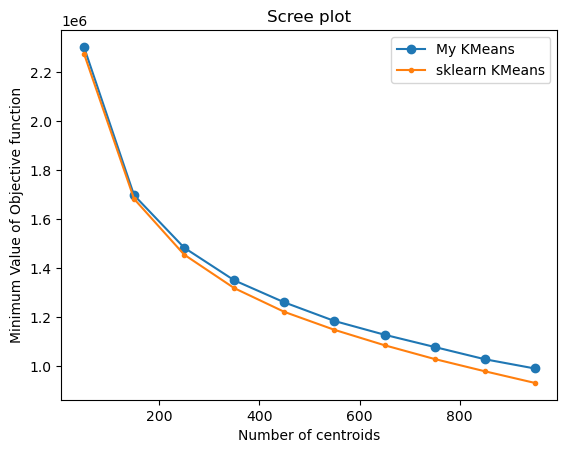

In [12]:
plt.plot(res_k[:, 0], res_k[:, 1], "o-", label="My KMeans")
plt.plot(np.arange(kmin, kmax, kstep), obj_list_skl, ".-", label="sklearn KMeans")
plt.title("Scree plot")
plt.ylabel("Minimum Value of Objective function")
plt.xlabel("Number of centroids")
plt.legend()

# Compute the transition matrix: $\pi_{\alpha, \beta} = P(\beta, \tau | \alpha, 0)$, for a given $\tau$

In [13]:
def transition_matrix(data, labels, k, tau):
    """
    Compute the transition matrix for transitions between every possible pair of microstates.
    --------------------------------
    data: np.ndarray which is 2D
    labels: array with assignations of which cluster ID each data point belongs to.
    k: number of clusters (from KMeans/KMedoids etc)
    tau: time lag
    """

    pi = np.zeros((k, k))
    for i in range(data.shape[0] - tau):
        alpha = labels[i]
        beta = labels[i + tau]
        pi[alpha, beta] += 1

    # print(pi)
    # print(np.sum(pi,axis=1,keepdims=True))

    pi = pi / np.sum(pi, axis=1, keepdims=True)

    # Check properties of a stochastic matrix
    # 1. All elements are positive-defined -> non-negative
    # 2. sum_(alpha) Pi(alpha,beta) = 1 (for all beta)
    assert np.size(np.where(pi < 0)[0]) == 0
    assert np.allclose(np.sum(pi, axis=1), 1.0, atol=1.0e-08)
    # print(pi)

    # eigvals, eigvecs = eig(pi.T) # equivalent to taking left eigenvector
    eigvals, eigvecs = eig(pi, left=True, right=False)

    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    sorted_eigvecs = eigvecs[:, sorted_index]

    statdist = eigvecs[:, np.isclose(eigvals, 1)].ravel()
    statdist /= np.sum(statdist)

    relaxation_timescales = -tau / np.log(np.abs(eigvals[np.isclose(eigvals, 1) == False]))

    # print(relaxation_timescales)
    # print(relaxation_timescales.shape)

    return sorted_eigvals, sorted_eigvecs, relaxation_timescales, statdist

# Inspect the sign of the leading eigenvectors to identify the Markov states


1328043.3088695342 21


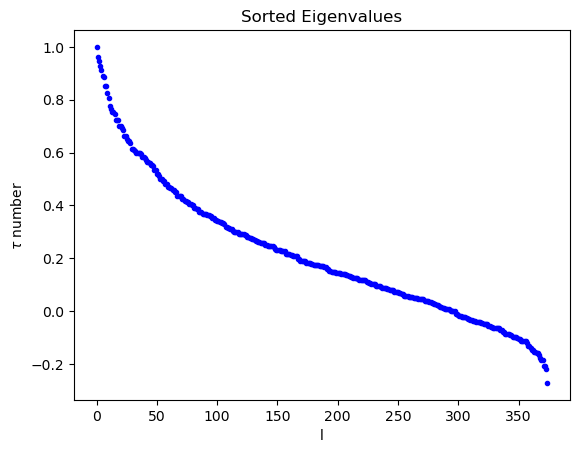

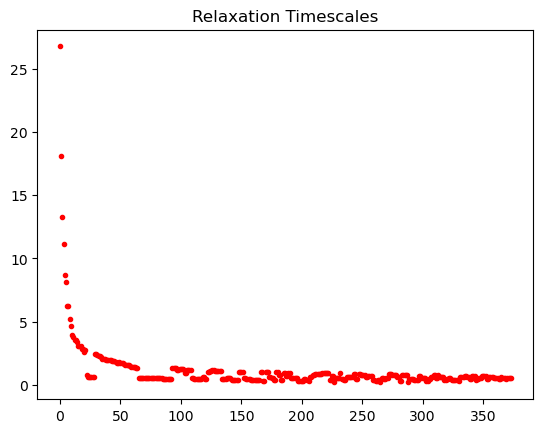

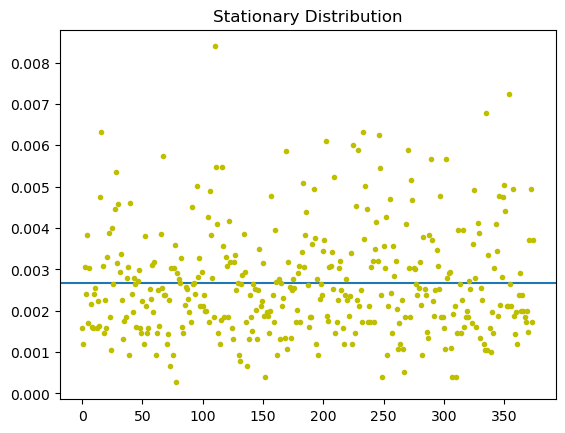

In [14]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 1
eigvals, eigvecs, relaxation_timescales, statdist = transition_matrix(data, labels.astype(np.int64), k, tau)

# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

plt.title("Stationary Distribution")
plt.axhline(statdist.mean())
plt.plot(statdist, "y.")
plt.show()

In [15]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2
num_ms = 2**num_timescales  # number of markov states is square of the number of relevant timescales

In [16]:
# Array to denote which centroid belongs to which Markov State
ms = np.zeros(k)

# print(ms)

# left eigenvectors of Pi sum to 0 except the first eigenvector
# which corresponds to eigenvalue=1 (equilibrium prob distribution)
assert np.isclose(eigvecs[:, 1::].sum(axis=0), 0.0, atol=1.0e-08).all()

if num_ms == 1:
    for i in range(k):
        if eigvecs[i, 1] > 0:
            # evec[:,1] corresponds to the first eigenvector with a non=1 eigenvalue
            # since log of the eigval is taken, so that eigenvector (evec[:,0], eigval=1) is ignored
            ms[i] = -1
        else:
            ms[i] = +1
elif num_ms == 4:
    for i in range(k):
        if eigvecs[i, 1] > 0 and eigvecs[i, 2] > 0:
            ms[i] = -2
        elif eigvecs[i, 1] > 0 and eigvecs[i, 2] < 0:
            ms[i] = -1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] > 0:
            ms[i] = +1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] < 0:
            ms[i] = +2
else:
    print("Not explicitly implemented for more than 2 relevant timescales")

In [17]:
# Attempt to automate this markov state discovery pipeline for any general number of chosen relevant timescales
# There may be bugs here

# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2

# number of markov states is square of the number of relevant timescales
num_markov_states = num_timescales**2

markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

assert np.isclose((ms - markov_states), 0).all()
# print(markov_states)
# print(ms)
# print(ms-markov_states)

In [18]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-2.0 2.0


# Dimensional Reduction of original data and visualization of the Markov States

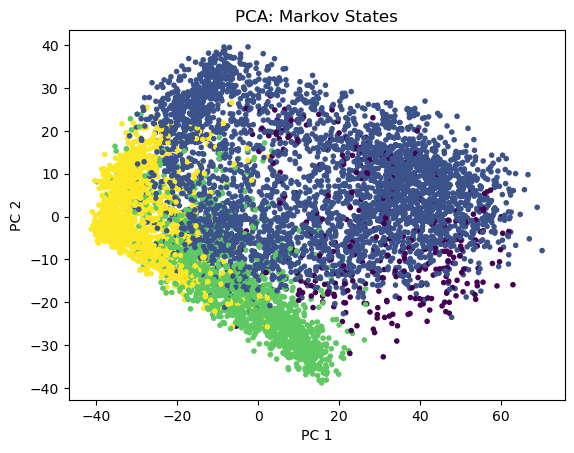

In [19]:
# 4: Dimensionality reduction and visualization
# Perform PCA on the microstates to obtain a 2D embedding

pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

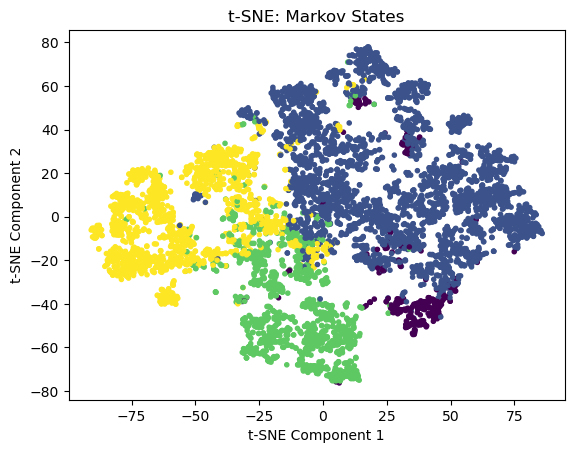

In [20]:
# 4: Dimensionality reduction and visualization
# Perform t-SNE on the microstates to obtain a 2D embedding
# perplexity refers to number of nearest neighbours chosen

data_2d_tsne = TSNE(n_components=2, perplexity=31, random_state=1729).fit_transform(data)

# Plot the Markov states in the embedding
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], marker=".", c=data_ms_assignation)
plt.title("t-SNE: Markov States")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Stability of results w.r.t. $\tau$ and $k$

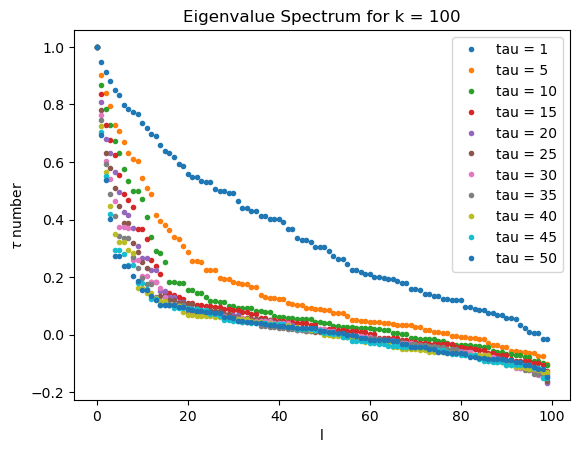

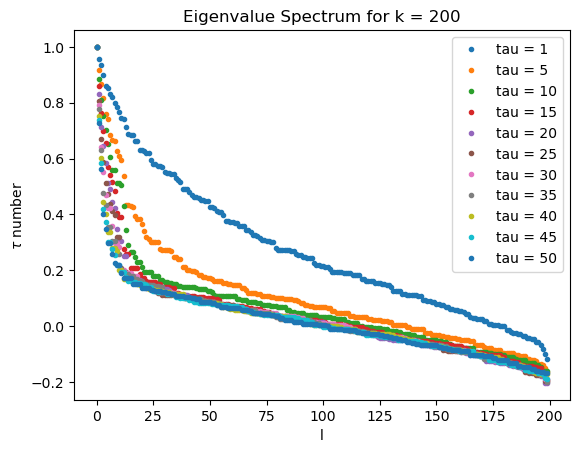

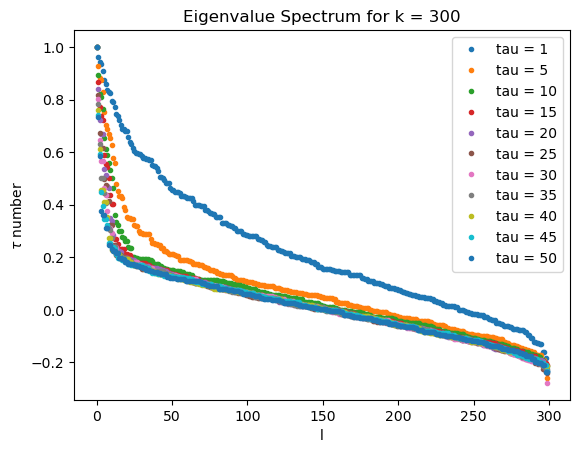

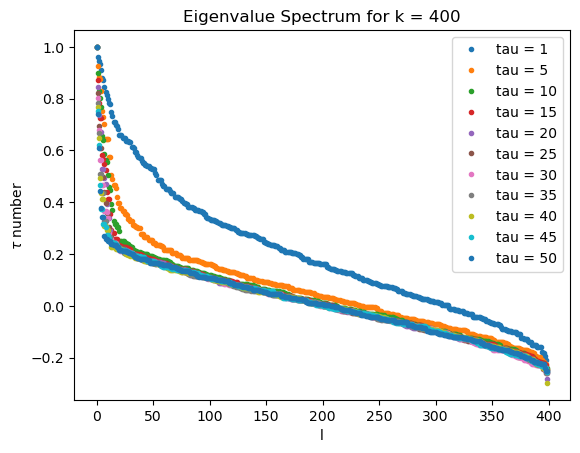

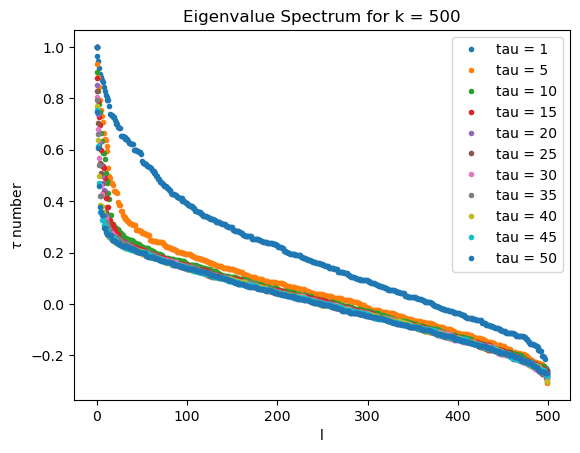

CPU times: user 51.9 s, sys: 13.2 s, total: 1min 5s
Wall time: 20.9 s


In [21]:
%%time

ks = np.ones((5))
ks = np.cumsum(ks) * 100
# 100, ...., 500

taus = np.ones((11))
taus = np.cumsum(taus) * 5 - 5 + 1
taus[1:] = taus[1:] - 1
taus = taus.astype(np.int64)
# 1, 5, 10, ...., 50

for i in range(len(ks)):
    k_local = ks[i].astype(np.int64)
    kmi = kmeans(k_local)
    kmi.fit(data=data, init="random")
    labels_ks = kmi.get_assignation()
    labels_ks = labels_ks.astype(np.int64)

    title_text = "Eigenvalue Spectrum for k = %d" % (k_local)
    plt.title(title_text)
    plt.xlabel(r"l")
    plt.ylabel(r"$\tau$ number")

    # title_text = "Relaxation Timescales for k = %d" % (k_local)
    # plt.title(title_text)

    # results = Parallel(n_jobs=2)(
    #    delayed(transition_matrix)(data, labels_ks, k_local, taus[t]) for t in range(len(taus))
    # )

    # eigvals_ks = np.array([results[i][0] for i in range(len(taus))])

    # for i in range(len(taus)):
    #    plt.plot(eigvals_ks[i, :], ".", label=f"tau = {taus[i]}")

    for t in range(len(taus)):
        eigvals_ks, eigvecs_ks, relaxation_timescales_ks, statdist_ts = transition_matrix(
            data, labels_ks, k_local, taus[t]
        )
        plt.plot(eigvals_ks, ".", label=f"tau = {taus[t]}")
    #    plt.plot(relaxation_timescales_ks, ".", label=f"tau = {taus[t]}")

    plt.legend()
    plt.show()

## One observes that the eigenvalue spectrum is similar regardless of the value of $k$ chosen.

## For each $k$, only the behaviour of $\tau = 1$ is significantly different than other values of $\tau$, from $1-50$.

## So, let us also visualize the Markov States for a higher value of $\tau = 50$ (keeping $k = 375$ constant)

1349435.546872244 16


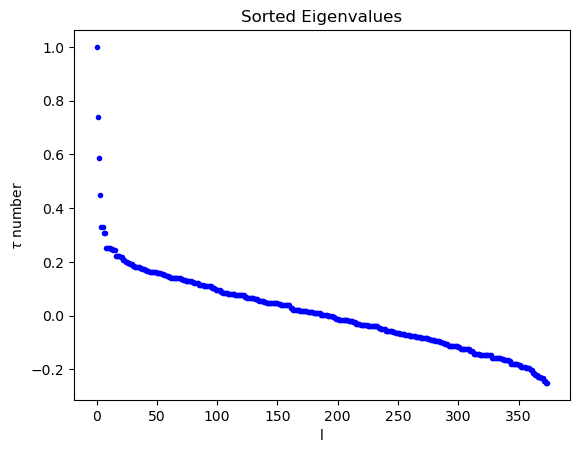

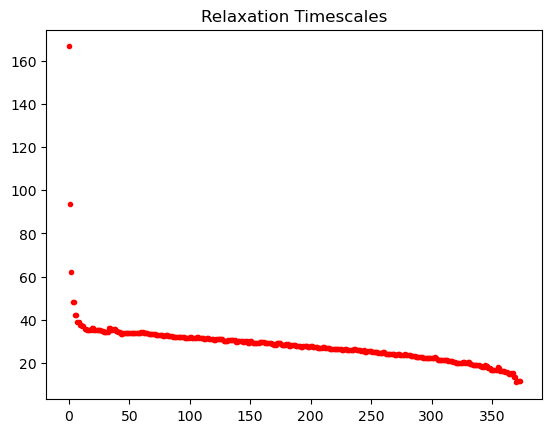

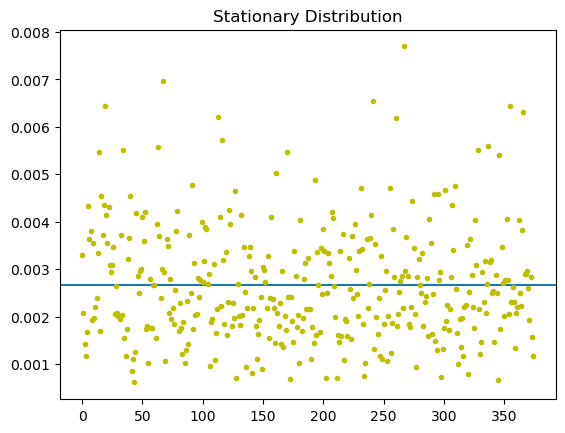

(375, 177)


In [22]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 50
eigvals, eigvecs, relaxation_timescales, statdist = transition_matrix(data, labels.astype(np.int64), k, tau)

# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

plt.title("Stationary Distribution")
plt.axhline(statdist.mean())
plt.plot(statdist, "y.")
plt.show()

# centroid_positions = km.get_centroid_positions()
print(centroid_positions.shape)

In [23]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2
num_ms = num_timescales**2  # number of markov states is square of the number of relevant timescales

In [24]:
markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

# print(markov_states)

In [25]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-2.0 2.0


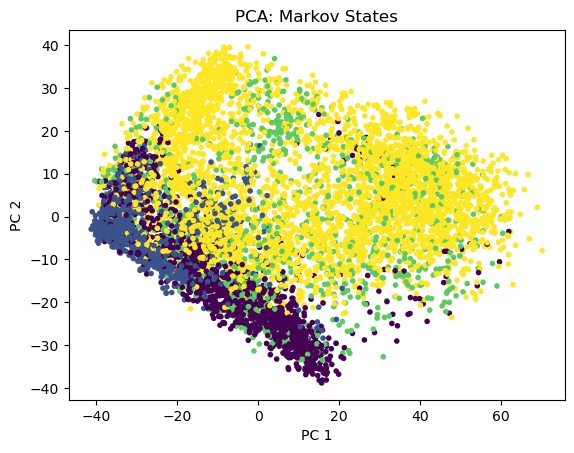

In [26]:
pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()